In [300]:
%matplotlib inline
import numpy as np
from sklearn.feature_extraction.image import extract_patches_2d
from numpy.lib import stride_tricks
import cv2
from matplotlib.colors import hsv_to_rgb
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3)

class PatchMatch(object):
    def __init__(self, a, b, patch_size):
        assert a.shape == b.shape, "Dimensions were unequal for patch-matching input"
        
        self.orig_shape = a.shape
        self.patch_size = patch_size
        self.offset_from_edge = self.patch_size // 2
        offset_from_edge = self.offset_from_edge
        self.a = a.copy()
        self.b = b.copy()
        
        self.a_padded = np.pad(a,pad_width=((0,0),(offset_from_edge,offset_from_edge),(offset_from_edge,offset_from_edge)),mode='reflect')
        
        self.b_padded = np.pad(b,pad_width=((0,0),(offset_from_edge,offset_from_edge),(offset_from_edge,offset_from_edge)),mode='reflect')
        
        
        self.nnf = np.ndarray(shape=(2, a.shape[1], a.shape[2]),dtype=np.int32)
        self.nnd = np.ndarray(shape=(a.shape[1], a.shape[2]),dtype=np.float32)

        #print(self.a.shape)
        #print(self.b.shape)
        #print("SHAPE OF PADDED a {}".format(self.a_padded.shape))
        #print("SHAPE OF PADDED b {}".format(self.b_padded.shape))

        for i in range(0, a.shape[1] ): #loop  through y
            for j in range(0, a.shape[2]): # loop through x
                self.nnf[0][i][j] = np.random.randint(0,a.shape[2])
                
                self.nnf[1][i][j] = np.random.randint(0,a.shape[1])
#                 print("{}   {}".format(self.nnf[0][i][j],self.nnf[1][i][j]))
                self.nnd[i][j] = self.calculate_distance(j,i,self.nnf[0][i][j],self.nnf[1][i][j])
                
    def clean_coords(self,x,y):
        assert x >= self.offset_from_edge and x < self.orig_shape[2] , "X coordinate off"
        assert y >= self.offset_from_edge and y < self.orig_shape[1] , "Y coordinate off"
        
    def _pad_matrix(self, matr):
        offset_from_edge = self.offset_from_edge
        return np.pad(matr,pad_width=((0,0),(offset_from_edge,offset_from_edge),(offset_from_edge,offset_from_edge)),mode='reflect')
    
    def calculate_distance(self,ax,ay,bx,by):

        patch_a = self.get_patch_for_coords(self.a_padded,ax,ay)
        patch_b = self.get_patch_for_coords(self.b_padded,bx,by)
        
#         print(patch_a.shape)
#         print(patch_b.shape)
        assert patch_a.shape == patch_b.shape, " ax {}  ay {}  bx {}  by {} a.shape = {}  b.shape={}".format(ax,ay,bx,by,patch_a.shape,patch_b.shape)


        diff = patch_a - patch_b
        distances = np.linalg.norm(diff,axis=0)
#         print("DISTANCE {}".format(distances.size))
        average = np.sum(distances)/(distances.size)
        return average
        
        
    
    def get_patch_for_coords(self, arr, x, y,patch_size=None):
        """
        Get a patch of at max patch_size X patch_size.
        x and y denotes the center of the patch

        :arr: an array of dimensions C * H * W 
        :return:
        """
#         x,y = self.clip_coords(x,y)
        if patch_size is None:
            patch_size = self.patch_size
        
        return arr[:,y: y + patch_size,
                     x : x+patch_size ]
        
    def propagate(self):
        old_nnd = self.nnd.copy()
        #print(self.nnd)
        #print("-"*10)
        for i in range(1,self.orig_shape[1]): # loop through ys
            for j in range(1,self.orig_shape[2]):# loop through xs
                current_pos_distance = self.calculate_distance(j,i,self.nnf[0][i][j],self.nnf[1][i][j])
                
                horiz_x = j - 1
                horiz_y = i
                horiz_dist = self.calculate_distance(j,i,self.nnf[0][horiz_y][horiz_x],self.nnf[1][horiz_y][horiz_x])
                
                vert_x = j 
                vert_y = i - 1  
                vert_dist = self.calculate_distance(j,i,self.nnf[0][vert_y][vert_x],self.nnf[1][vert_y][vert_x])

                best_dist = min(current_pos_distance,horiz_dist,vert_dist)
                
                if best_dist == current_pos_distance:
                    best_x = j
                    best_y = i
                elif best_dist == horiz_dist:
                    best_x = horiz_x
                    best_y = horiz_y
                elif best_dist == vert_dist:
                    best_x = vert_x
                    best_y = vert_y
                else:
                    print("NOOOO")
                    
                rand_d = min(self.a.shape[1]//2, self.a.shape[2]//2)
                
                while rand_d > 0:
                        xmin = max(best_x - rand_d, 0)
                        xmax = min(best_x + rand_d, self.b.shape[2])
                        ymin = max(best_y - rand_d, 0)
                        ymax = min(best_y + rand_d, self.b.shape[1])

                        rand_x = np.random.randint(xmin, xmax)
                        rand_y = np.random.randint(ymin, ymax)
                        val = self.calculate_distance(j,i, rand_x, rand_y)
                        if val < best_dist:
                            best_x, best_y, best_dist = rand_x, rand_y, val
                        rand_d = rand_d // 2    
              
                self.nnf[0][i][j] = best_x 
                self.nnf[1][i][j] = best_y
                self.nnd[i][j] = best_dist
            
    
    def get_loss_value(self):
        return np.sum(self.nnd)
    def clip_coords(self,x,y):
        return max(x,0) , max(y,0)
    
    def reconstruct_img_alt(self, patch_size=3,arr_v=None):
        if patch_size is None:
            patch_size = self.patch_size
        
        padded_nnf = self._pad_matrix(self.nnf).copy()
        print("padded_nnf SHAPE IS {}".format(padded_nnf.shape)) # (2, 3, 3)


        b_prime = np.zeros_like(self.a,dtype=np.uint8)
        
        for i in range(self.a.shape[1]): #traverse down a
            for j in range(self.a.shape[2]): #traverse across a
                
                #get patch around (i,j) in nnf
#                 print("i {} ,, j {}".format(i,j))
                nnf_patch = self.get_patch_for_coords(padded_nnf, j, i,patch_size=patch_size)
                warped_patch = np.zeros(shape=(3, patch_size, patch_size), dtype=self.b.dtype)
#                 print("**"*8)
#                 print("NNF PATCH SHAPE IS {}".format(nnf_patch.shape)) # (2, 3, 3)
#                 print(self.b.shape) # 3,200,200
#                 print(warped_patch.shape) # 3x3x3


                #warp the patch with pixel values from b according to nnf locations
                for p_x in range(nnf_patch.shape[1]):
                    for p_y in range(nnf_patch.shape[2]):
#                         print(self.b[:, nnf_patch[p_x], nnf_patch[p_y]])
#                         print("*"*10)
#                         print(warped_patch[:, p_x, p_y])
#                         print(p_x)
#                         print(p_y)
                        warped_patch[:, p_x, p_y] = arr_v[:, nnf_patch[0][p_x][p_y], nnf_patch[1][p_x][p_y]]
#                         print(self.b[:, nnf_patch[0][p_x][p_y], nnf_patch[1][p_x][p_y]])
#                 break
                #average the pixels in the warped patch to get the reconstructed image's pixel
                averaged_patch = warped_patch.sum(axis=(1,2))/(patch_size*patch_size)
                b_prime[:, i, j] = averaged_patch[:]
                
        b_prime = b_prime.transpose(1,2,0)[:, :, ::-1]
        plt.imshow(b_prime)
    
    def reconstruct_img(self,patch_size=3):
        if patch_size is None:
            patch_size = self.patch_size
            
        img = np.zeros(shape=(3,200,200),dtype=np.uint8)

        for i in range(200):
            for j in range(200):
                t_x = self.nnf[0][i][j] 
                t_y = self.nnf[1][i][j]
                
#                 print("J {} I {} NNF x {} NNF y {}".format(i,j,t_x,t_y))
#                 patch = self.get_patch_for_coords(self.b_padded, t_y, t_x,patch_size=patch_size)
#                 average_vote = patch.sum(axis=(1,2))/(patch_size*patch_size)
                
                img[0][i][j] = self.a[0][t_y][t_x]
                img[1][i][j] = self.a[1][t_y][t_x]
                img[2][i][j] = self.a[2][t_y][t_x]
        
        plt.imshow(img.transpose(1,2,0))
       
        
    def back_propagate(self):
            old_nnd = self.nnd.copy()
            #print(self.nnd)
            #print("-"*10)
            for i in range(self.orig_shape[1]-2,0,-1): # loop through ys
                for j in range(self.orig_shape[2]-2,0,-1):# loop through xs
                    current_pos_distance = self.nnd[i][j] 

                    horiz_x = j + 1
                    horiz_y = i
                    horiz_dist = self.calculate_distance(j,i,self.nnf[0][horiz_y][horiz_x],self.nnf[1][horiz_y][horiz_x])

                    vert_x = j 
                    vert_y = i + 1  
                    vert_dist = self.calculate_distance(j,i,self.nnf[0][vert_y][vert_x],self.nnf[1][vert_y][vert_x])

                    best_dist = min(current_pos_distance,horiz_dist,vert_dist)

                    if best_dist == current_pos_distance:
                        best_x = j
                        best_y = i
                    elif best_dist == horiz_dist:
                        best_x = horiz_x
                        best_y = horiz_y
                    elif best_dist == vert_dist:
                        best_x = vert_x
                        best_y = vert_y

                    rand_d = min(self.a.shape[1]//2, self.a.shape[2]//2)

                    while rand_d > 0:
                            xmin = max(best_x - rand_d, 0)
                            xmax = min(best_x + rand_d, self.b.shape[2])
                            ymin = max(best_y - rand_d, 0)
                            ymax = min(best_y + rand_d, self.b.shape[1])

                            rand_x = np.random.randint(xmin, xmax)
                            rand_y = np.random.randint(ymin, ymax)
                            val = self.calculate_distance(j,i, rand_x, rand_y)
                            if val < best_dist:
                                best_x, best_y, best_dist = rand_x, rand_y, val
                            rand_d = rand_d // 2    

                    self.nnf[0][i][j] = best_x 
                    self.nnf[1][i][j] = best_y
                    self.nnd[i][j] = best_dist
            #print(self.nnd)
            #print("_"*10)
            #print(old_nnd-self.nnd)



In [307]:
# test_a = np.random.randint(low=0,high=10,size=(7,100, 100))
# test_b = np.random.randint(low=0,high=10,size=(7,100, 100))

x = cv2.imread("./aa.jpg")
y = cv2.imread("./bb.jpg")
z = cv2.imread("./aa3.jpg")


x = cv2.resize(x,(200,300))
y = cv2.resize(y,(200,300))
z = cv2.resize(z,(200,300))
print(x.shape)
a = x.transpose(2,0,1)[::-1,:,:]
b = y.transpose(2,0,1)[::-1,:,:]
z = z.transpose(2,0,1)[::-1,:,:]

# a = a.transpose(1,2,0) 
# b = b.transpose(1,2,0)
print(a.shape)


# plt.imshow(a)
# plt.show()
# plt.imshow(b.transpose(2,1,0))
# plt.show()
# plt.imshow(z.transpose(2,1,0))

(300, 200, 3)
(3, 300, 200)


(300, 200)


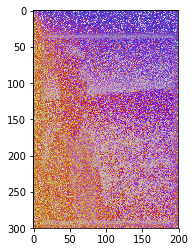

iteration 1


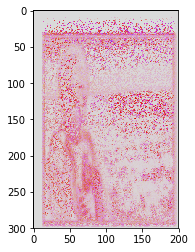

padded_nnf SHAPE IS (2, 304, 204)


IndexError: index 285 is out of bounds for axis 2 with size 200

In [308]:
pm = PatchMatch(a,b, 5)
# pm.reconstruct_img_alt(3,z)
print(pm.nnd.shape)
visualize_nnf(pm.nnf,pm.nnd)

plt.show()
def do():
    patch_size=7
#     pm = PatchMatch(a,b, patch_size)
    for i in range(10):
        print('iteration {}'.format(i+1))
        pm.propagate()
#         pm.back_propagate()
        visualize_nnf(pm.nnf,pm.nnd)
        plt.show()
#         pm.reconstruct_img()
#         plt.show()
        pm.reconstruct_img_alt(1,z)
#         plt.show()
#         pm.reconstruct_img_alt(1,z)
#         plt.show()
#         pm.reconstruct_img_alt(1,a)


        plt.show()
do()

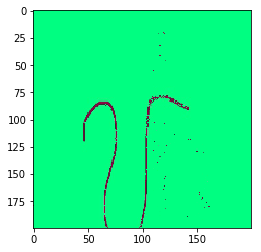

In [303]:
pm.reconstruct_img()

#plt.imshow(np.rot90(pm.b.transpose(1,2,0)[:, :, ::-1]))
plt.show()

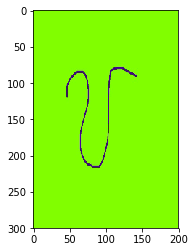

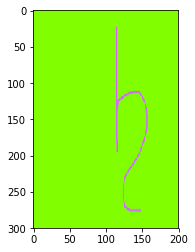

In [304]:
plt.imshow(x)
plt.show()
plt.imshow(y)
plt.show()

In [ ]:
pm.propagate()
pm.back_propagate()
pm.propagate()
pm.back_propagate()
pm.propagate()
pm.back_propagate()
pm.reconstruct_img(patch_size=3)
plt.show()

In [ ]:
pm.reconstruct_img(patch_size=3)
plt.show()
pm.reconstruct_img(patch_size=1)
plt.show()
pm.reconstruct_img(patch_size=5)
plt.show()



In [ ]:
reconstruct()

In [ ]:
pm.get_patch_for_coords(x,0,0)

(3, 275, 183)


In [ ]:
x[:,0:3,0:3]

In [ ]:
pm.a[:,7+2,8+2]

In [ ]:
pm.nnf[:,0,0] = [2,2]

In [ ]:
pm.nnf[:,0,0]

In [ ]:
x = cv2.imread("/Users/harshvardhangupta/Deep-Image-Analogy/notebooks/Unknown.jpeg").transpose(2,1,0)
# x = x[:,:4,:4]
# x

In [ ]:
np.pad(x,pad_width=((0,0),(1,1),(1,1)),mode='constant')

In [ ]:
pm.get_patch_for_coords(pm.a_padded,5,5)

In [ ]:
x[:,y+self.offset_from_edge: y + self.patch_size , x+self.offset_from_edge : x+self.patch_size]

In [ ]:
x[:,36+1 : 36 + 4 , 36+1 : 36+4]

In [ ]:
ax 36  ay 0  bx 182  by 8

In [ ]:
x[:,8+1:8+3,182+1:182+3]

In [ ]:
x.shape

In [ ]:
padded_x = np.pad(x,pad_width=((0,0),(1,1),(1,1)),mode='constant')

In [ ]:
x.shape

In [ ]:
padded_x

In [ ]:
padded_x[:,8:8+4,182:182+3]

In [281]:
from matplotlib.colors import hsv_to_rgb
import matplotlib.pyplot as plt
import numpy as np
np.seterr(all='raise')

def unit_vector(vector):
    try:
        result = vector / np.linalg.norm(vector)
        return result
    except:
#         print(vector)
#         print(np.linalg.norm(vector))
        return [0.0,0.0]
    
test_list = []
def angle_between(v1, v2):
    v1, v2 = np.array(v1,dtype=np.float32), np.array(v2,dtype=np.float32)
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    assert v1_u is not None , "V1 none"
    assert v2_u is not None , "V2 none"
    test_list.append(np.rad2deg(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))))
#     print(v1_u)
#     print(v2_u)
    
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def norm_dist(arr):
    return (arr)/(arr.max())

def visualize_nnf(nnf, nnd):
    img = np.zeros((nnf.shape[1], nnf.shape[2], 3),dtype=np.float32)
    for i in range(1, nnf.shape[1]):
        for j in range(1, nnf.shape[2]):
            angle = angle_between_alt([j, i], [nnf[0, i, j], nnf[1, i, j]])

            img[i, j, :] = np.array([angle, nnd[i,j], 350])
    img = hsv_to_rgb(norm_dist(img))
#     print(np.unique(img))

    plt.imshow(img)

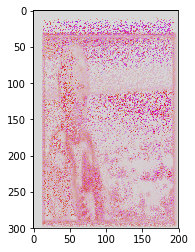

In [282]:
visualize_nnf(pm.nnf,pm.nnd)

[ 0.     0.16   0.16  ...,  0.978  0.978  1.   ]


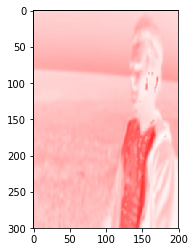

In [137]:
visualize_nnf(pm.nnf,pm.nnd)

In [226]:

# def unit_vector(vector):
#     """ Returns the unit vector of the vector.  """
#     return vector / np.linalg.norm(vector)

# def angle_between(v1, v2):

#     v1_u = unit_vector(v1)
#     v2_u = unit_vector(v2)
#     return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))


# def visualize_nnf(nnf, nnd):
#     img = np.zeros((nnf.shape[1], nnf.shape[2], 3),dtype=np.float32)
#     for i in range(1, nnf.shape[1]):
#         for j in range(1, nnf.shape[2]):
#             angle = angle_between_al([j, i], [nnf[0, i, j], nnf[1, i, j]])
#             img[i, j, :] = np.array([angle, nnd[i,j], 1.0])
#     img = hsv_to_rgb(norm_dist(img*255))
#     plt.imshow(img)

In [225]:
# tx = np.array([1,1],dtype=np.int32)
# ty = np.array([0,0],dtype=np.int32)


# angle_between((0, 0), (1,1))

FloatingPointError: invalid value encountered in true_divide

In [ ]:
plt.imshow(pm.nnd.T/255)

In [ ]:
pm.nnd.shape

In [ ]:
pm.nnf.shape

In [ ]:
def reconstruct():
    img = np.zeros(shape=(3,200,200),dtype=np.uint8)

    for i in range(200):
        for j in range(200):
            t_x = pm.nnf[0][i][j] 
            t_y = pm.nnf[1][i][j]
    #         print(t_x)
    #         print(t_y)
    #         print()
            img[0][i][j] = y[0][t_y][t_x]
            img[1][i][j] = y[1][t_y][t_x]
            img[2][i][j] = y[2][t_y][t_x]
    #         print(y[0][t_y][t_x])
    #         print(y[1][t_y][t_x])
    #         print(y[2][t_y][t_x])
    #         print()
    #         print(np.unique(img))

    #         print(img[0,j,i])
    #         print(img[1,j,i])
    #         print(img[2,j,i])
    #         print()
    plt.imshow(img.transpose(2,1,0)[:,:,::-1]*255)
    print(np.unique(img))

In [ ]:
reconstruct()

In [ ]:
np.unique(img)

In [ ]:
y[:,20:50,20:50]

In [ ]:
img.shape

In [ ]:
plt.imshow(img.transpose(2,1,0)[:,:,::-1])

In [ ]:
plt.imshow(pm.a_padded.transpose(2,1,0))

In [ ]:
pm.a.shape

In [ ]:
plt.imshow(a.transpose(1,2,0))

In [ ]:
plt.imshow(b.transpose(1,2,0))

In [ ]:
pm.nnd.shape

In [ ]:
plt.imshow(pm.nnd)

In [ ]:
padded_nnf = pm._pad_matrix(pm.nnf)

In [ ]:
nnf_patch = pm.get_patch_for_coords(padded_nnf, 0, 53,patch_size=3)
nnf_patch.shape


In [ ]:
for i in range(200):
    for j in range(200):
        print(" j{} i{} NNFx--{} NNFy--{} ".format(j,i,pm.nnf[0][i][j] , pm.nnf[1][i][j]))
        if j == pm.nnf[0][i][j] and i ==pm.nnf[0][i][j]:
            print("SAME")

In [ ]:
np.unique(pm.nnf)

In [ ]:
np.histogram(pm.nnf[0])

In [22]:
0/0

ZeroDivisionError: division by zero

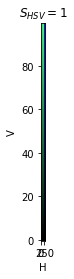

In [89]:
V, H = np.mgrid[0:1:100j, 0:1:300j]
S = np.ones_like(V)
HSV = np.dstack((H,S,V))
RGB = hsv_to_rgb(HSV)
plt.imshow(RGB, origin="lower", extent=[0, 360, 0, 1], aspect=150)
plt.xlabel("H")
plt.ylabel("V")
plt.title("$S_{HSV}=1$")
plt.show()

In [182]:
np.unique(np.array(test_list))

array([  0.000e+00,   1.978e-02,   2.798e-02,   3.426e-02,   3.956e-02,
         4.423e-02,   4.846e-02,   5.234e-02,   5.595e-02,   5.935e-02,
         6.256e-02,   6.561e-02,   6.853e-02,   7.133e-02,   7.402e-02,
         7.662e-02,   7.913e-02,   8.156e-02,   8.393e-02,   8.623e-02,
         8.847e-02,   9.065e-02,   9.279e-02,   9.487e-02,   9.691e-02,
         9.891e-02,   1.009e-01,   1.028e-01,   1.047e-01,   1.065e-01,
         1.084e-01,   1.101e-01,   1.119e-01,   1.136e-01,   1.153e-01,
         1.170e-01,   1.187e-01,   1.219e-01,   1.235e-01,   1.251e-01,
         1.282e-01,   1.297e-01,   1.312e-01,   1.327e-01,   1.342e-01,
         1.356e-01,   1.371e-01,   1.385e-01,   1.399e-01,   1.413e-01,
         1.427e-01,   1.440e-01,   1.454e-01,   1.467e-01,   1.480e-01,
         1.507e-01,   1.520e-01,   1.532e-01,   1.545e-01,   1.558e-01,
         1.570e-01,   1.583e-01,   1.607e-01,   1.619e-01,   1.631e-01,
         1.643e-01,   1.655e-01,   1.667e-01,   1.679e-01,   1.7

In [181]:
np.set_printoptions(threshold=np.nan)

In [202]:
# def angle_between(v1, v2):

#     v1_u = unit_vector(v1)
#     v2_u = unit_vector(v2)
#     return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
angle_between([0, 1], [5, 5])

0.78539819

In [221]:
import numpy as np

def angle_between_alt(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))

In [223]:
angle_between_alt([0,0],[1,1])

315.0